***
# Processing of Zivid and projector pair calibration:
***
This notebook is inspired from this notebook [Bingyao Huang](https://bingyaohuang.github.io/Calibrate-Kinect-and-projector/).
## Table of contents
* [General info](#Generate-the-Projected-Checkerboard-Image)
* [Setup](#setup)
* [Procedure](#procedure)


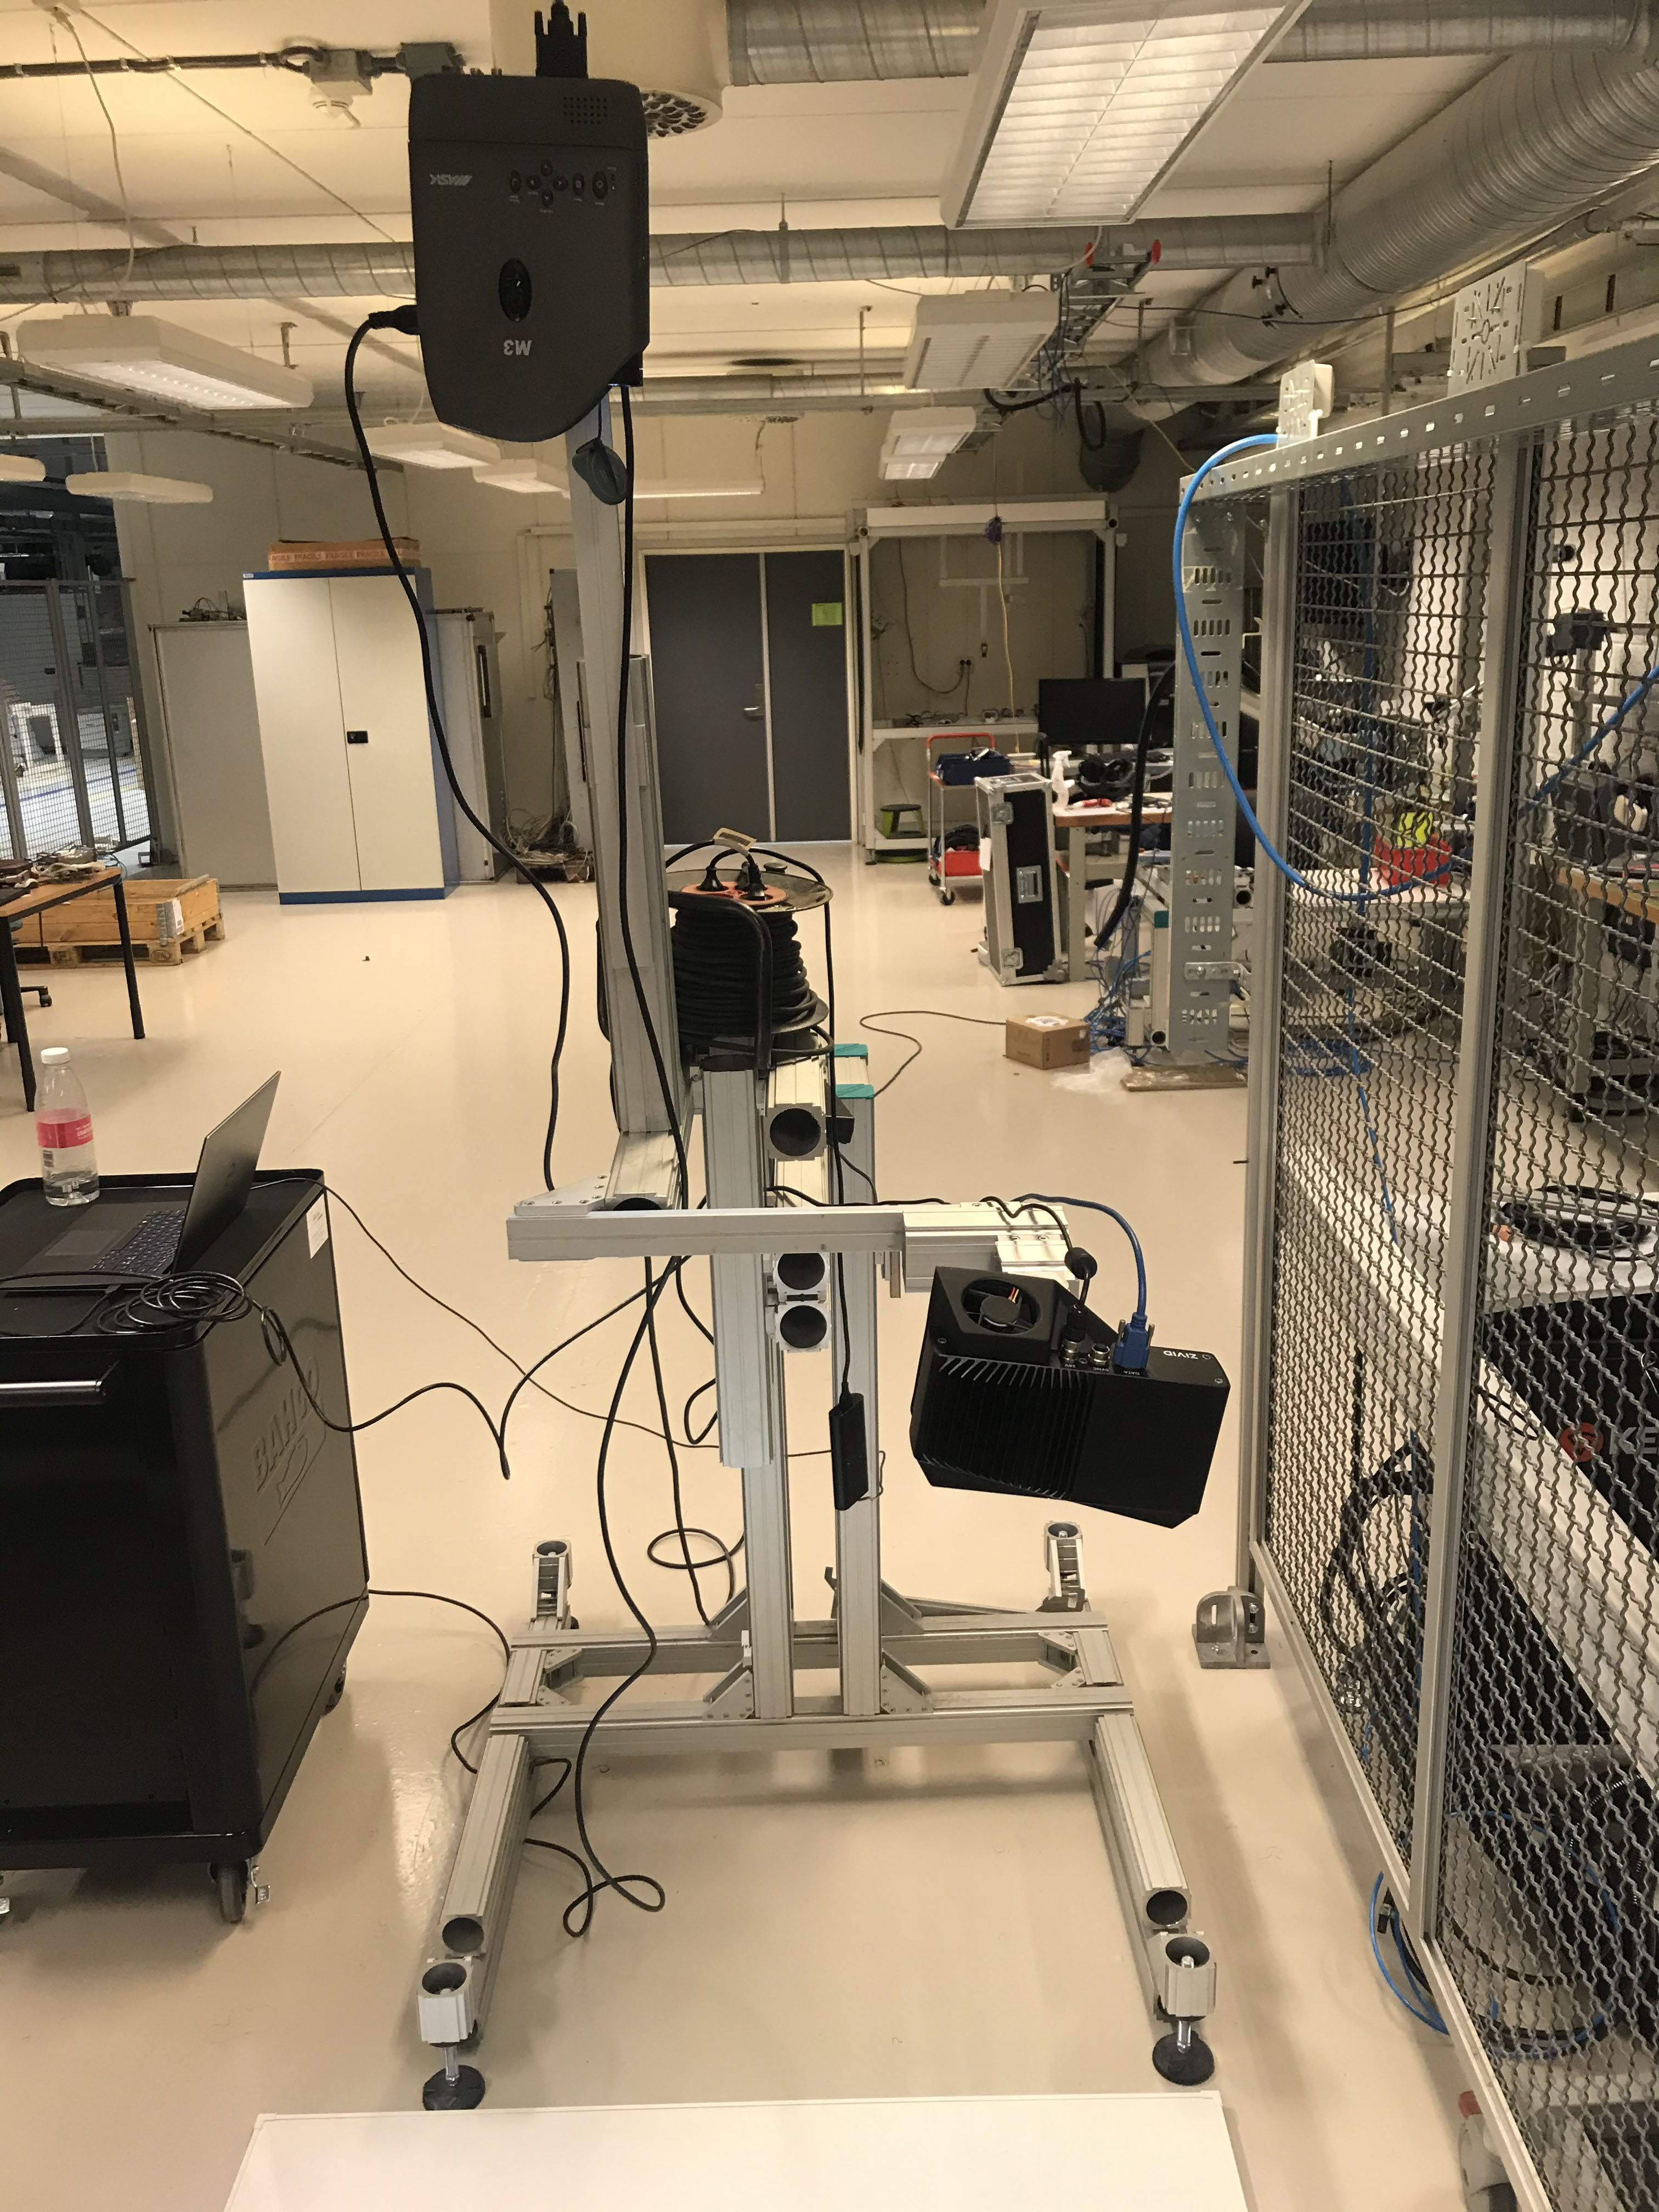

***
## Generate the Projected Checkerboard Image
This notebook explains the processing theory behind the Zivid and the projector pair calibration. The method require that you have a depth camera with the belonging intrinsics parameters to find the xyz points for the corresponding pixel cordinates. The focus is to calibrate the intrinsic parameters of the projector and the extrinsic parameters between the projector and the Zivid depth camera without using a printed checkerboard.

Let's say you have projected the generated checkerboard image in your external projector and captured a number of X different poses with the depth camera and saved it in a desired location. When the generated checkerboard image were made, then the inner corner pixel cordinates were saved as: 
*** 
 $$\mathbf{P}^{\text{2d}}_{\text{p}} = [\mathbf{q}_0, \mathbf{q}_1,\dots \mathbf{q}_i, \dots \mathbf{q}_{K}]$$
***
where $\mathbf{q}_i = [ u_i, v_i ]$ are the correspondent pixel cordinates of the $i^\text{th}$ in the projctor image space and $K$ are the dependent on the projector resoultion, checkerboard square size and the spacing(x and y) into the squares. The used checkerboard had squares of 10 columns and 7 rows, which means 9 columns and 6 rows of inner corners. The saved cordinates in $\mathbf{P}^{\text{2d}}_{\text{p}}$ are generated from the code below:
***

In [10]:
import numpy as np
P_p_2d = []
width = 1024 #The projector width resoultion
height = 768 #The projector height resoultion
cols = 10 # Number of colums
rows = 7 # Number of rows
square_size = 90 #The square size in pixels
def savep_p_2d(width,height, cols, rows, square_size, P_p_2d):
    xspacing = (width - cols * square_size) / 2.0
    yspacing = (height - rows * square_size) / 2.0

    for y in range(int(yspacing),height-int(yspacing), square_size): #Iterate over row by row
        if (y + square_size > height -int(yspacing)): 
            break
        for x in range(int(xspacing), width-int(xspacing), square_size): #terate over each column in each row
            if (x + square_size > width -int(xspacing)):
                break
            if(x > int(xspacing) and y > int(yspacing)):   
                P_p_2d = np.append(P_p_2d, np.array([x,y]))
    P_p_2d = np.reshape(P_p_2d, (-1,2))
    #print(P_p_2d)
savep_p_2d(width,height, cols, rows, square_size, P_p_2d)

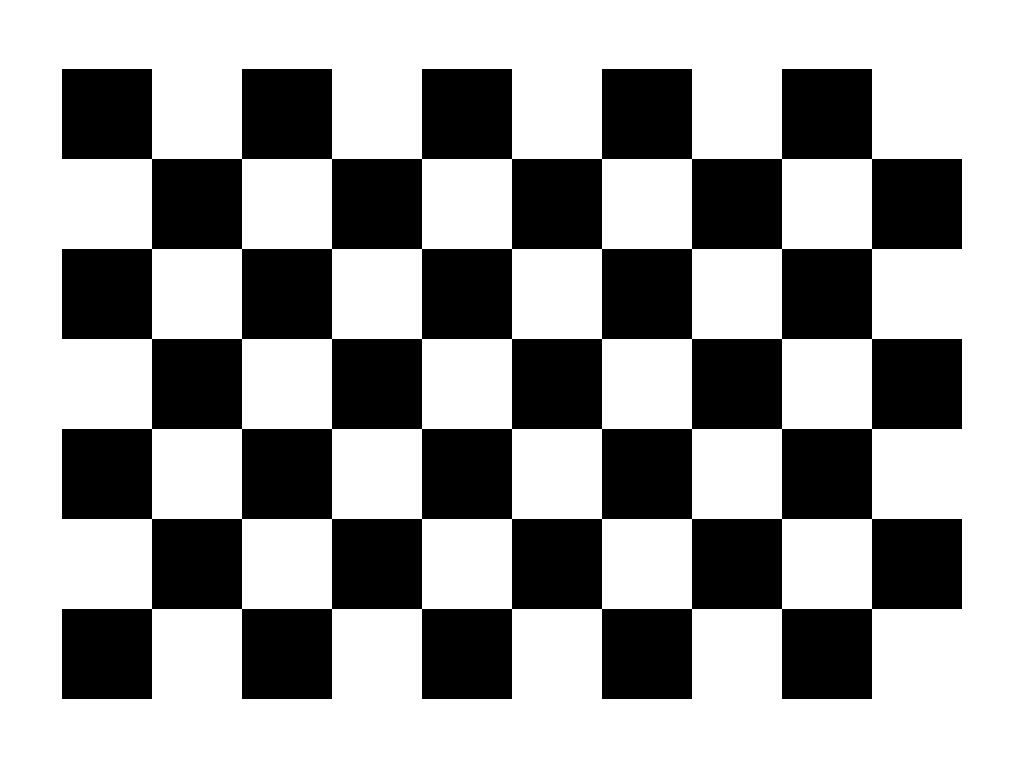

***
Another soloution to save the pixel cordinates could be to use the OpenCV function [findChessboardCorners](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#findchessboardcorners) for the generated image from running the script ```python gen_pattern.py``` and look at the cordinates saved by this function.
***

## Interpolate Noisy Data
Depending on the projected surface and the how bright the projector are projecting, it can make noise, which can make the zivid camera not able to capture the depth.The returned values in the point cloud are nan values. The correspondent pixel cordinate to were it cant capture depth would be nan, and therefore it is neeeded to define a number of pixels around this cordinate to interpolate around. A workaround for this either to go for the nearest interpolation or a linear interpoplation for a number of pixels around the nan value. The code below use [scipy.interpolate.griddata](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html) to determine a nan value. Either by nearest or linear interpolation. The code below show a method for interpolating 3D data.

In [12]:
def interpolatexyz(array, u,v, px, method):
    ''' Input:
        Array - A array Array[v][u] returns the xyz cordinate for the correspondent pixel cordinate in the zivid camera image.
        u - The u pixel cordinate that is a nan value.
        v - The v pixel cordinate that is a nan value.
        px- A number of px around the nan value to interpolate around.
        
        Output: The interpolated value determined by the values of pixels around.
    '''
    xyz = array[v-px:v+px+1, u-px:u+px+1]
    x_indx,y_indx,z_indx = np.meshgrid(np.arange(0, np.shape(xyz)[0]),np.arange(0,np.shape(xyz)[1]), np.arange(0,np.shape(xyz)[2]))
        
    array_masked = np.ma.masked_invalid(xyz)
    valid_xs = x_indx[~array_masked.mask]
    valid_ys = y_indx[~array_masked.mask]
    valid_zs = z_indx[~array_masked.mask]
    validarr = array_masked[~array_masked.mask]
        
    xyz_interp = griddata((valid_xs, valid_ys, valid_zs), validarr.ravel(),
                                    (x_indx, y_indx, z_indx), method='method')
    return xyz_interp[px][px]

##  2D-3D Cordinates
Given a Zivid-captured color checkerboard image, we first need to extract the checkerboard pixel cordinates in the zivid camera image space $\mathbf{P}^{\text{2d}}_{\text{c}}$ using OpenCV's [findChessboardCorners](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#findchessboardcorners). Then the $\mathbf{P}^{\text{2d}}_{\text{c}}$ corresponding 3D cordinates in the zivid depth camera's view space could be direct quiered from the zivid xyz-array. Another solutiuon is to map from the $\mathbf{P}^{\text{2d}}_{\text{c}}$ pixel cordinates to 3D cordinates using the intrinsics parameters of the zivid camera and the depth value for each checkerboard corner. We define the 3D-world cordinates as:
***
$$\mathbf{P}^\text{3d} = [ \mathbf{x}_0, \mathbf{x}_1,\dots \mathbf{x}_i, \dots \mathbf{x}_{N-1} ]$$
***
where $\mathbf{x}_i = [ x_i, y_i, z_i ]$ as the correspinding 3D cordinate of $\mathbf{P}^{\text{2d}}_{\text{c}}[i]$. The resoultion of the zivid camera is 1920x1200 pixels and for every pixel, XYZ (mm), RGB (8-bit), and SNR can be provided, where SNR is the Signal-to-Noise Ratio. The data is stored as a matrix of shape $[1920,1200,7]$. An important thing is to iterate over the right order so $\mathbf{P}^\text{3d}$ match ther order in $\mathbf{P}^{\text{2d}}_{\text{c}}$. The corner colors points in the image below represent the order of the points in $\mathbf{P}^{\text{2d}}_{\text{c}}$, red is the first element in $\mathbf{P}^{\text{2d}}_{\text{c}}$ vector and dark blue is the last one.
***

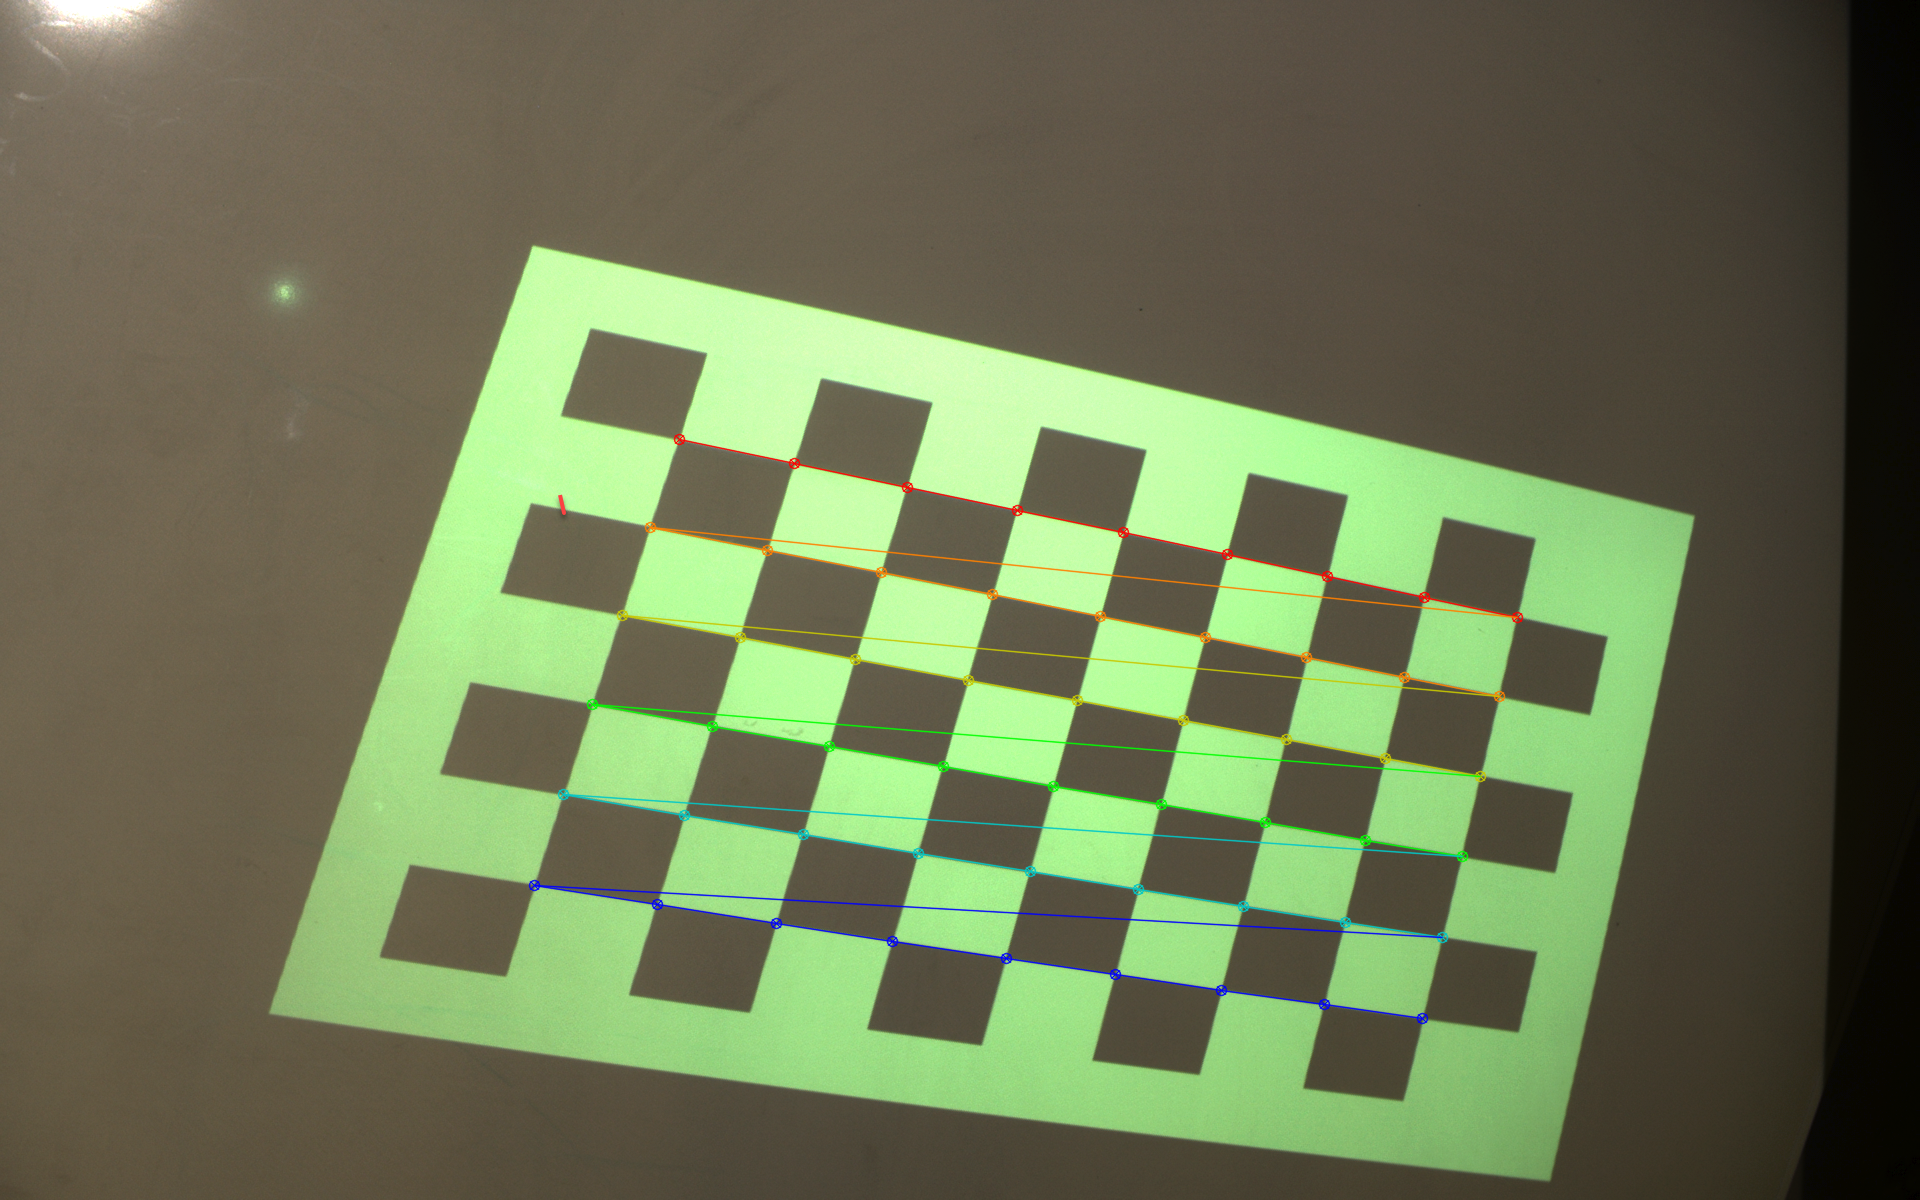

***
Since $\mathbf{P}^{\text{2d}}_{\text{p}}$ is given by the function savep_p_2d, we have the 3D cordinates in zivid depth space and the 2D cordinates in the external prokjector image space. The corrospodence pairs are images($\mathbf{P}^\text{3d}$ and $\mathbf{P}^{\text{2d}}_{\text{p}}$). We can now use these pairs to calibrate the projector intrinsics parameters an the extrinsics parameters betweeen the zivid camera and the external projector. In the OpenCVs function [calibrateCamera](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#calibratecamera) requires that the Z value of the $objectpoints$ array must be equal to zero. This is because Zhangs-method assumes all objectpoints reside on the xy plane of the checkerboar's object space. If we plot the $\mathbf{P}^\text{3d}$ we can see that the Z value are nonzero, because the $\mathbf{P}^\text{3d}$ cordinates are defined in the zivid camera depth space.
***

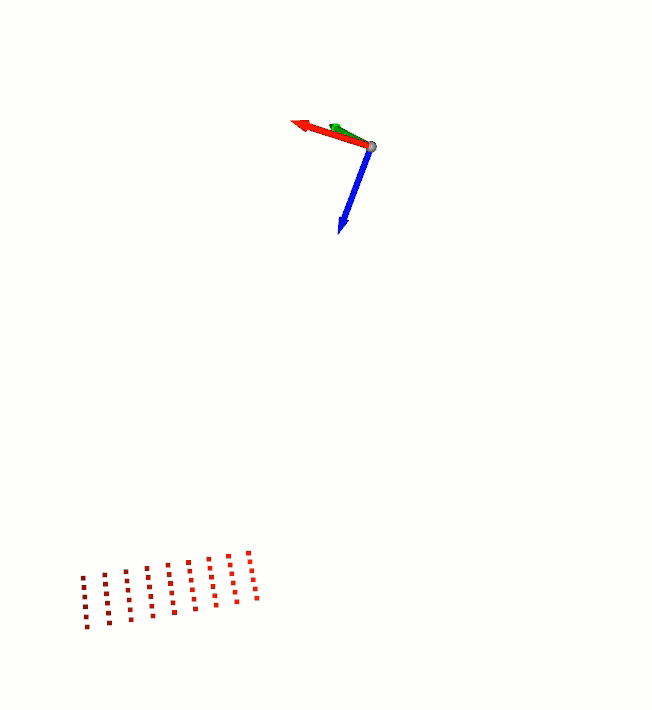

***
One can may ask can we generate the 3D cordinates of these checkerboard corners like what we did with the conventional printed checkerboard? The answer is no, unlike a printed checckerboard, the projected one is disorted and skewed due to projector's perspective projection. The disortion varies each time we change the oriantation of the plane it is projected onto. So each chceckerboard image varies every time due to the distance from the plane to the projector. The shape would look like a diamond as in the gif with order of inner corner points.
***

***
$\mathbf{\text{Gradient Tree Boosting Algorithm}}$<br>
***
1.&emsp;Initialize model with a constant value $$f_{0}(x) = \textrm{arg min}_{\gamma} \sum \limits _{i=1} ^{N} L(y_{i}, \gamma)$$
2.&emsp;For m = 1 to M:<br>
&emsp;&emsp;(a)&emsp;For $i = 1,2,...,N$ compute<br>
    $$r_{im} = - \displaystyle \Bigg[\frac{\partial L(y_{i}, f(x_{i}))}{\partial f(x_{i})}\Bigg]_{f=f_{m−1}}$$
&emsp;&emsp;(b)&emsp;Fit a regression tree to the targets $r_{im}$ giving terminal regions<br>
&emsp;&emsp;&emsp;&emsp;$R_{jm}, j = 1, 2, . . . , J_{m}.$<br><br>
&emsp;&emsp;(c)&emsp;For $j = 1, 2, . . . , J_{m}$ compute<br>
$$\gamma_{jm} = \underset{\gamma}{\textrm{arg min}} \sum \limits _{x_{i} \in R_{jm}} L(y_{i}, f_{m−1}(x_{i}) + \gamma)$$
<br>
&emsp;&emsp;(d)&emsp;Update $f_{m}(x) = f_{m−1}(x) + \sum _{j=1} ^{J_{m}} \gamma_{jm} I(x \in R_{jm})$<br><br>
3. Output $\hat{f}(x) = f_{M}(x)$
***